## 方針
1. トランザクション系データを使って集約特徴量を作成する
    -  pd.DataFrame.groupby().agg(aggs)でまとめて特徴量作るのが楽。
2. マスタデータにトランザクション系データをマージ
3. マージ後のデータで、複数のトランザクション系データの特徴量を使った特徴量を作成
4. 学習と予測
    - ロイヤルティに対するの回帰予測(ロイヤルティを離散化した上で分類予測も可)
    - 外れ値かどうかの予測をし、外れ値の確率が高いものについては、ルールベースで対処

In [ ]:
import datetime
import gc
import warnings
from pathlib import Path
from typing import List

import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')
np.random.seed(4590)

DATADIR = Path('./input')
tr_path = DATADIR / 'train.csv'
test_path = DATADIR / 'test.csv'
hist_trans_path = DATADIR / 'historical_transactions.csv'
new_merchant_trans_path = DATADIR / 'new_merchant_transactions.csv'

train = pd.read_csv(tr_path)
test = pd.read_csv(test_path)
hist_trans = pd.read_csv(hist_trans_path)
new_merchant_trans = pd.read_csv(new_merchant_trans_path)

# データ前処理

- null埋め
- purchase_dateをstrからdatetimeに変換した上で特徴ごとに切り分け
- `Y or N`でラベリングされている特徴量を`0 or 1`へ変換

In [2]:
def trans_fillna(df: pd.DataFrame) -> pd.DataFrame:
    """fill na for some features in hist_trans and new_merchant_trans"""
    df['category_2'].fillna(1.0,inplace=True)
    df['category_3'].fillna('A',inplace=True)
    df['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)
    return df
                                                        
def purchasedate_str2timedate(df: pd.DataFrame) -> pd.DataFrame:
    """convert 'purchase_date' from str to timedate features in featureshist_trans and new_merchant_trans.
       New features are year, weekofyear, month, dayofweek, weekend and hour.
    """
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['year'] = df['purchase_date'].dt.year
    df['weekofyear'] = df['purchase_date'].dt.weekofyear
    df['month'] = df['purchase_date'].dt.month
    df['dayofweek'] = df['purchase_date'].dt.dayofweek
    df['weekend'] = (df.purchase_date.dt.weekday >=5).astype(int)
    df['hour'] = df['purchase_date'].dt.hour
    return df

def YN2binaryLabel(df: pd.DataFrame) -> pd.DataFrame:
    """convert string label to binary label(0 or 1)"""
    df['authorized_flag'] = df['authorized_flag'].map({'Y':1, 'N':0})
    df['category_1'] = df['category_1'].map({'Y':1, 'N':0})
    return df

for df in [hist_trans, new_merchant_trans]:
    df = trans_fillna(df)
    df = purchasedate_str2timedate(df)
    df = YN2binaryLabel(df)

# 特徴量作成

なんやこれ

In [3]:
def create_month_diff(df: pd.DataFrame) -> pd.DataFrame:
    """https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/73244"""
    df['month_diff'] = ((datetime.datetime.today() - df['purchase_date']).dt.days)//30
    df['month_diff'] += df['month_lag']
    return df

def create_category_purchase_amount_mean(df: pd.DataFrame) -> pd.DataFrame:
    """なんやこれ"""
    df['category_2'+'_mean'] = df.groupby(['category_2'])['purchase_amount'].transform('mean')
    df['category_3'+'_mean'] = df.groupby(['category_3'])['purchase_amount'].transform('mean')
    return df

for df in [hist_trans, new_merchant_trans]:
    df = create_month_diff(df)
    df = create_category_purchase_amount_mean(df)

hist_transに対して集約処理で特徴量を作成
- aggsを辞書型で作成して、keyにcolumn名、valueに集約処理を入れる。
    - skewとかパーセンタイル処理とかも入れたいな
- category_2, category_3でgroupbyしてpruchase_amountのmean取ってる理由って何？

In [4]:
def get_aggs() -> dict:
    """Get a dictionary for pd.DataFrameGroupBy.agg.
    Retruns:
        A disctionaly: key is column name, value is a list of aggrigation operations.
    """
    aggs = {}
        
    aggs['month'] = ['nunique']
    aggs['hour'] = ['nunique']
    aggs['weekofyear'] = ['nunique']
    aggs['dayofweek'] = ['nunique']
    aggs['year'] = ['nunique']
    aggs['subsector_id'] = ['nunique']
    aggs['merchant_id'] = ['nunique']
    aggs['merchant_category_id'] = ['nunique']
    
    aggs['purchase_amount'] = ['sum','max','min','mean','var']
    aggs['installments'] = ['sum','max','min','mean','var']
    aggs['purchase_date'] = ['max','min']
    aggs['month_lag'] = ['max','min','mean','var']
    aggs['month_diff'] = ['mean']
    aggs['authorized_flag'] = ['sum', 'mean']
    aggs['weekend'] = ['sum', 'mean']
    aggs['category_1'] = ['sum', 'mean']
    aggs['card_id'] = ['size']
    aggs['category_2_mean'] = ['mean']
    aggs['category_3_mean'] = ['mean']

    return aggs

aggs = get_aggs()

In [5]:
def get_new_columns(aggs: dict) -> List[str]:
    """Get a new column names list with prefix and aggrigation operations.
    Args:
        aggs (list): a dictionary, key is column name, value is a list of aggrigation operations.
    Returns:
        A list of new column names (list)
    """
    return [k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

In [6]:
# get_new_columsで特徴量の名前を付与。
new_columns = get_new_columns(aggs)

# 作った集約処理の辞書をgroupby.aggで適用。
hist_trans_group = hist_trans.groupby('card_id').agg(aggs)
hist_trans_group.columns = new_columns
hist_trans_group.reset_index(drop=False,inplace=True)

new_merchant_trans_group = new_merchant_trans.groupby('card_id').agg(aggs)
new_merchant_trans_group.columns = new_columns
new_merchant_trans_group.reset_index(drop=False,inplace=True)

追加で特徴量作成

In [7]:
def create_purchase_date_features(df_group: pd.DataFrame) -> pd.DataFrame:
    """Create featreus from aggrigated features on 'purchase_date'."""
    df_group['purchase_date_diff'] = (df_group['purchase_date_max'] - df_group['purchase_date_min']).dt.days
    df_group['purchase_date_average'] = df_group['purchase_date_diff']/df_group['card_id_size']
    df_group['purchase_date_uptonow'] = (datetime.datetime.today() - df_group['purchase_date_max']).dt.days
    return df_group


# new_hist_new_colname = ['card_id'] + ['hist_' + name for name in new_merchant_trans_group if name not in ['card_id']]

hist_trans_group = create_purchase_date_features(hist_trans_group)
hist_new_colname = ['card_id']
hist_new_colname.extend(['hist_' + name for name in hist_trans_group.columns.drop('card_id')])
hist_trans_group.columns = hist_new_colname

new_merchant_trans_group = create_purchase_date_features(new_merchant_trans_group)
# new_hist_new_colname = ['card_id']
# new_hist_new_colname.extend(['new_hist_' + name for name in new_merchant_trans_group.columns.drop('card_id')])
new_hist_new_colname = ['card_id'] + ['new_hist_' + name for name in new_merchant_trans_group if name not in ['card_id']]
new_merchant_trans_group.columns = new_hist_new_colname

`card_id`のマスタである`train`と`test`へ集約処理で特徴量を作った`hist_trans_group`と`new_merchant_trans_group`をマージ。

In [8]:
train = train.merge(hist_trans_group,on='card_id',how='left')
test = test.merge(hist_trans_group,on='card_id',how='left')
del hist_trans_group;gc.collect()

train = train.merge(new_merchant_trans_group,on='card_id',how='left')
test = test.merge(new_merchant_trans_group,on='card_id',how='left')
del new_merchant_trans_group;gc.collect()

49

### 外れ値ラベルを作成

In [9]:
train['outliers'] = 0
train.loc[train['target'] < -30, 'outliers'] = 1
train['outliers'].value_counts()

0    199710
1      2207
Name: outliers, dtype: int64

### `hist_trans`と`new_merchant_trans`の両方を加味した特徴量の作成 

In [10]:
def first_active_month_str2timedate(df: pd.DataFrame) -> pd.DataFrame:
    """convert 'first_activate_month' from str to timedate in train and test
    これ最初でよくね？名前悪くね？"""
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['dayofweek'] = df['first_active_month'].dt.dayofweek
    df['weekofyear'] = df['first_active_month'].dt.weekofyear
    df['month'] = df['first_active_month'].dt.month
    df['elapsed_time'] = (datetime.datetime.today() - df['first_active_month']).dt.days
    df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['new_hist_first_buy'] = (df['new_hist_purchase_date_min'] - df['first_active_month']).dt.days
    return df
    
def convert_purchase_date_features(df: pd.DataFrame) -> pd.DataFrame:
    """わからん、これここじゃなくてよくね？"""
    df['hist_purchase_date_max'] = df['hist_purchase_date_max'].astype(np.int64) * 1e-9
    df['hist_purchase_date_min'] = df['hist_purchase_date_min'].astype(np.int64) * 1e-9
    df['new_hist_purchase_date_max'] = df['new_hist_purchase_date_max'].astype(np.int64) * 1e-9
    df['new_hist_purchase_date_min'] = df['new_hist_purchase_date_min'].astype(np.int64) * 1e-9
    return df

def create_transaction_total(df: pd.DataFrame) -> pd.DataFrame:
    """create features based on total number of transactions"""
    df['card_id_total'] = df['new_hist_card_id_size']+df['hist_card_id_size']
    df['purchase_amount_total'] = df['new_hist_purchase_amount_sum']+df['hist_purchase_amount_sum']
    return df

def mapping_outliers_label(df: pd.DataFrame) -> pd.DataFrame:
    """わからん"""
    for f in ['feature_1','feature_2','feature_3']:
        order_label = train.groupby([f])['outliers'].mean()
        df[f] = df[f].map(order_label)
    return df

In [11]:
for df in [train, test]:
    df = first_active_month_str2timedate(df)
    df = convert_purchase_date_features(df)
    df = create_transaction_total(df)
    df = mapping_outliers_label(df)

# 学習

In [12]:
train_columns = [c for c in train.columns if c not in ['card_id', 'first_active_month','target','outliers']]
target = train['target']
del train['target']

In [14]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4590}

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

- folds.splitにtrain['outliers']が入っているのは外れ値がtrainとvalに偏りなく入るため？

In [16]:
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train,train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(train.iloc[val_idx][train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target))

fold 0
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.66643	valid_1's rmse: 3.72108
[200]	training's rmse: 3.59028	valid_1's rmse: 3.68785
[300]	training's rmse: 3.54494	valid_1's rmse: 3.67445
[400]	training's rmse: 3.50915	valid_1's rmse: 3.66653
[500]	training's rmse: 3.47862	valid_1's rmse: 3.66234
[600]	training's rmse: 3.45348	valid_1's rmse: 3.65929
[700]	training's rmse: 3.43059	valid_1's rmse: 3.65705
[800]	training's rmse: 3.40937	valid_1's rmse: 3.65508
[900]	training's rmse: 3.38957	valid_1's rmse: 3.65415
[1000]	training's rmse: 3.3725	valid_1's rmse: 3.65322
[1100]	training's rmse: 3.35571	valid_1's rmse: 3.65223
[1200]	training's rmse: 3.34009	valid_1's rmse: 3.65216
Early stopping, best iteration is:
[1192]	training's rmse: 3.34129	valid_1's rmse: 3.65202
fold 1
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.66808	valid_1's rmse: 3.71565
[200]	training's rmse: 3.59045	valid_1's rmse: 3.683

3.6537205099608303

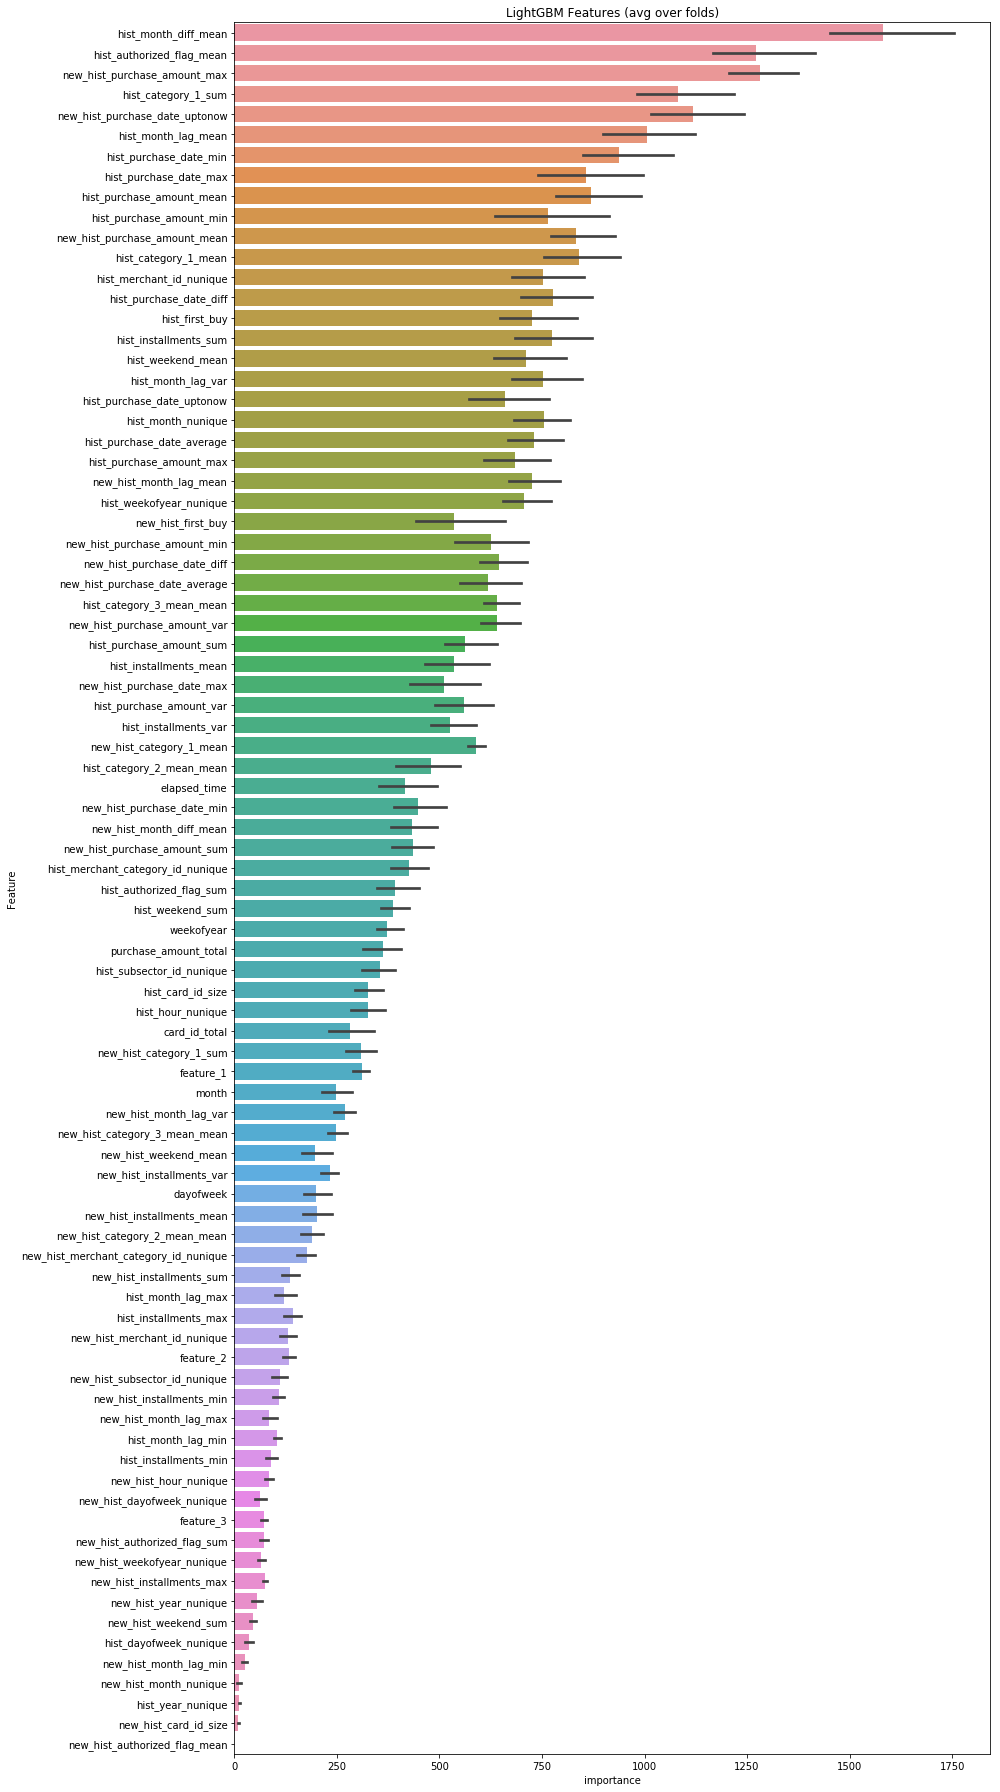

In [17]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')